#  Michaelis–Menten fitting

Inhibited enzyme reactions often follow what are known as _Michaelis–Menten_ kinetics, in which a reaction rate $v$ follows a law of the form

$$v(x) = \frac{V x}{K_m + x},$$ 


where $x$ is the concentration of a substrate. The real values $V$ and $K_m$ are parameters that are free to fit to data. For this example we cook up some artificial data with $V=2$ and $K_m=1/2$.

In [1]:
m = 25;
x = LinRange(0.05,6,m)
y = @. 2*x/(0.5+x)                   # exactly on the curve
@. y += 0.15*cos(2*exp(x/16)*x);     # noise added

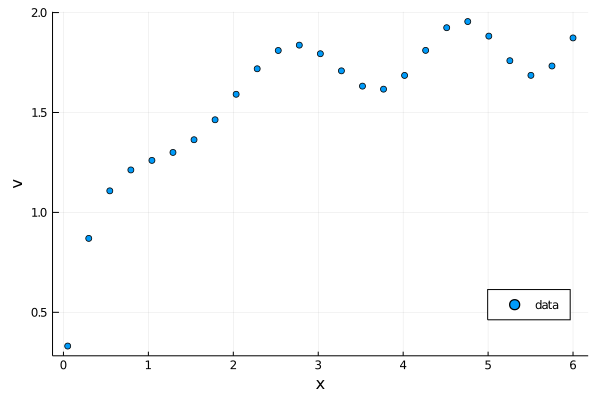

In [2]:
using Plots
scatter(x,y,label="data",xlabel="x",ylabel="v",leg=:bottomright)

The idea is to pretend that we know nothing of the origins of this data and use nonlinear least squares on the misfit to find the parameters in the theoretical model function $v(x)$. Note in the Jacobian that the derivatives are _not_ with respect to $x$, but with respect to the two parameters, which are contained in the vector `c`.

In [3]:
function misfit(c)
    V,Km = c   # rename components for clarity
    return @. V*x/(Km+x) - y
end

function misfitjac(c)
    V,Km = c   # rename components for clarity
    J = zeros(m,2)
    J[:,1] = @. x/(Km+x)              # d/d(V)
    J[:,2] = @. -V*x/(Km+x)^2         # d/d(Km)
    return J
end

misfitjac (generic function with 1 method)

In [7]:
using FundamentalsNumericalComputation

c1 = [1, 0.75]
c = FNC.newtonsys(misfit,misfitjac,c1)

@show V,Km = c[end]  # final values

(V, Km) = c[end] = [1.96865259837822, 0.4693037307416628]


The final values are close to the noise-free values of $V=2$, $K_m=0.5$ that we used to generate the data. We can calculate the amount of misfit at the end, although it's not completely clear what a "good" value would be. Graphically, the model looks reasonable.

In [10]:
model = x -> V*x/(Km+x)
using LinearAlgebra
@show final_misfit_norm = norm(model.(x)-y);

final_misfit_norm = norm(model.(x) - y) = 0.523399807641224


0.523399807641224

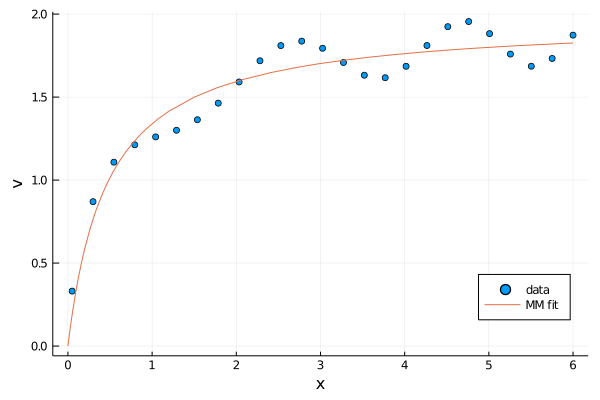

In [11]:
plot!(model,0,6,label="MM fit" )

For this model, we also have the option of linearizing the fit process. Rewrite the model as $1/v= (a/x)+b$ for the new parameters $\alpha=K_m/V$ and $\beta=1/V$. This corresponds to the misfit function whose entries are 

$$f_i(\alpha,\beta) = \alpha \cdot \frac{1}{x_i} + \beta - \frac{1}{y_i},$$ 

for $i=1,\ldots,m$. Although the misfit is nonlinear in $x$ and $y$, it's linear in the unknown parameters $\alpha$ and $\beta$, and so can be posed and solved as a linear least-squares problem.

In [13]:
A = [ x.^(-1) x.^0 ]
u = 1 ./ y
z =  A\u
α,β = z

2-element Array{Float64,1}:
 0.12476333709901535
 0.5713959100431232

The two fits are different, because they do not optimize the same quantities.

In [14]:
linmodel = x -> 1 / (β + α/x)
@show final_misfit_linearized = norm(linmodel.(x)-y);

final_misfit_linearized = norm(linmodel.(x) - y) = 0.7487111013097562


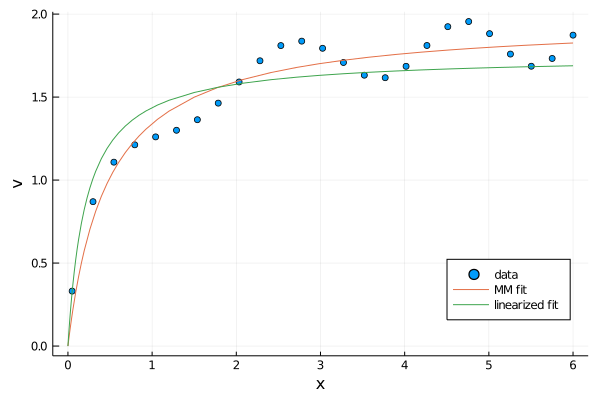

In [15]:
plot!(linmodel,0,6,label="linearized fit")

The truly nonlinear fit is better both in the residual norm and graphically.